MAE Test (Aug-GGN):10=0.0440
RMSE Test (Aug-GGN):10=0.0717


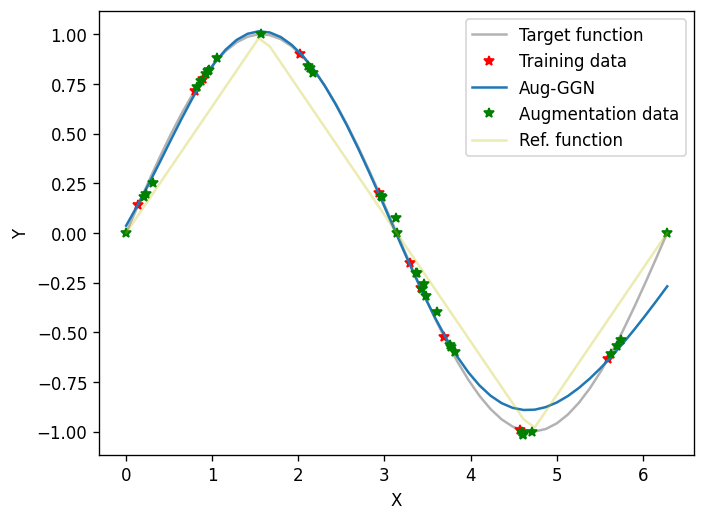

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error , mean_squared_error
import torch
import sympy as sp
import torch.nn as nn
import torch.nn.functional as F
from math import cos, sin, pi
import sympy as sp

def set_seed(seed=2023):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def generate_data(num_data, xlim):
    x_train = np.random.uniform(xlim[0], xlim[1], num_data)
    y_train = func(x_train)
    return x_train, y_train

def plot_results(x_test, y_test, y_pred, x_train, y_train, x_aug, y_aug,y_ref):
    plt.figure(dpi=120)
    plt.plot(x_test, y_test, 'k', alpha=0.3, label="Target function")
    plt.plot(x_train, y_train, 'r*', label="Training data")
    plt.plot(x_test, y_pred.numpy().reshape(-1), label="Aug-GGN")
    plt.plot(x_aug, y_aug, 'g*', label="Augmentation data")
    plt.plot(x_test, y_ref, 'y', alpha=0.3, label="Ref. function")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.show()

# Network architecture
class Net(nn.Module):
    def __init__(self, hidden_size=10):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        h = torch.sigmoid(self.fc1(x))
        x = self.fc2(h)
        return x, h

# Piece-wise linear reference model
def model(x):
    if x < pi / 2:
        return x / pi * 2
    elif x < 3 * pi / 2:
        return 2 - x / pi * 2
    else:
        return x / pi * 2 - 4

# Target function
def func(x):
    return np.sin(x)

# Gradient of reference model
def difference(x):    
    return 2 / pi if (x < pi / 2 or x >= 3 * pi / 2) else -2 / pi

def AGGN(num_data, model, func, difference):
    # For reproducibility
    set_seed()
    xlim = [0, 2*pi]
    noise_std= 0.1*2
    training_set_size = num_data  # Training set size
    training_set_size_d = 100   # Gradient sample size
    num_aug_generation_loop= 4  # Number of iteration for generating of data aug
    Beta=1
    alpha = 1/training_set_size
    num_epochs = 2000

    # Data, for sine function
    x = sp.Symbol('x')
    modelforzerofun = sp.Piecewise(
        (x / pi * 2, x < pi / 2),
        (2 - x / pi * 2, (x >= pi / 2) & (x < 3 * pi / 2)),
        (x / pi * 2 - 4, x >= 3 * pi / 2)
    )
    root_points = sp.solve(modelforzerofun, x)
    
    # Numpy vectorize
    model = np.vectorize(model)
    difference = np.vectorize(difference)
    root_points_y = model(root_points)
    x_train,y_train= generate_data(training_set_size, xlim)
    
    augmented_data_x = []
    augmented_data_y = []
    x_train_1_aug = x_train 
    y_train_1_aug = y_train 

    for i in range(1,num_aug_generation_loop):
        distance= np.random.uniform(0, noise_std, x_train.shape)
        x_train_2_aug = np.where(difference(x_train)*difference(x_train+distance) > 0,x_train+ distance ,x_train- distance)
        diff_x_train_1= difference(x_train)
        diff_x_train_2_aug= difference(x_train_2_aug)
        y_train_2_aug = y_train_1_aug + diff_x_train_1* (x_train_2_aug - x_train_1_aug)
        augmented_data_x.append(x_train_2_aug)
        augmented_data_y.append(y_train_2_aug)
        x_train_1_aug = x_train_2_aug 
        y_train_1_aug = y_train_2_aug 

    grad_zero_point = [pi/2, 3*pi/2]
    grad_zero_point_y =model(grad_zero_point)
    flattened_augmented_data_x = [item for sublist in augmented_data_x for item in sublist]
    flattened_augmented_data_y = [item for sublist in augmented_data_y for item in sublist]
    for item in grad_zero_point:
        flattened_augmented_data_x.append(item)
    for item in grad_zero_point_y:
        flattened_augmented_data_y.append(item)
    for item in root_points:
        flattened_augmented_data_x.append(float(item))
    for item in root_points_y:
        flattened_augmented_data_y.append(float(item))


    x_train_grad = np.linspace(xlim[0], xlim[1], num=training_set_size_d)
    y_train_grad = difference(x_train_grad)

    x_train  = torch.tensor(x_train, dtype=torch.float32).view((-1, 1))
    y_train = torch.tensor(y_train, dtype=torch.float32).view((-1, 1))
    flattened_augmented_data_x = torch.tensor(flattened_augmented_data_x, dtype=torch.float32).view((-1, 1))
    flattened_augmented_data_y = torch.tensor(flattened_augmented_data_y, dtype=torch.float32).view((-1, 1))
    x_train_grad = torch.tensor(x_train_grad, dtype=torch.float32).view((-1, 1))
    y_train_grad = torch.tensor(y_train_grad, dtype=torch.float32).view((-1, 1))


    # Target function
    x_test = np.linspace(xlim[0], xlim[1])
    y_test = func(x_test)
    y_ref = model(x_test)


    # Network, loss function, and optimizer
    net = Net(32)
    loss_func = nn.MSELoss()
    optimizer = torch.optim.AdamW(net.parameters(), lr=0.01)

    # Training
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        y_pred, _ = net(x_train)
        mse_train = loss_func(y_pred, y_train)
        mse_train.backward()
        optimizer.step()
        optimizer.zero_grad()
        y_pred_agu, _ = net(flattened_augmented_data_x)
        mse_aug = loss_func(y_pred_agu, flattened_augmented_data_y)*Beta
        mse_aug.backward()
        optimizer.step()
        optimizer.zero_grad()
        _, hidden = net(x_train_grad)
        dy_dx = net.fc2.weight * hidden * (1 - hidden) @ net.fc1.weight
        gn_mse = alpha * loss_func(dy_dx, y_train_grad)
        gn_mse.backward()
        optimizer.step()   

    # Prediction
    net.eval()
    with torch.no_grad():
        y_pred, _ = net(torch.tensor(x_test, dtype=torch.float32).view(-1, 1))
    mae_test = mean_absolute_error(y_test, y_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'MAE Test (Aug-GGN):{training_set_size}={mae_test:.4f}' )
    print(f'RMSE Test (Aug-GGN):{training_set_size}={rmse_test:.4f}')

    plot_results(x_test, y_test, y_pred, x_train, y_train, flattened_augmented_data_x, flattened_augmented_data_y, y_ref)



if __name__ == "__main__":
    AGGN(10, model,func, difference)
